In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv('../data/churn_feature_engineered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  int64  
 2   Age                 10000 non-null  int64  
 3   Tenure              10000 non-null  int64  
 4   Balance             10000 non-null  float64
 5   NumOfProducts       10000 non-null  int64  
 6   HasCrCard           10000 non-null  int64  
 7   IsActiveMember      10000 non-null  int64  
 8   EstimatedSalary     10000 non-null  float64
 9   Exited              10000 non-null  int64  
 10  Complain            10000 non-null  int64  
 11  Satisfaction Score  10000 non-null  int64  
 12  Point Earned        10000 non-null  int64  
 13  BalancePerProduct   10000 non-null  float64
 14  BalanceToSalary     10000 non-null  float64
 15  EngagementScore     10000 non-null  int64  
 16  Tenur

In [5]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned,BalancePerProduct,BalanceToSalary,EngagementScore,TenureGroup,CardTypeRank,Geography_Germany,Geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,2,464,0.00,0.000000,2,1,4,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,1,3,456,41903.93,0.744670,1,1,4,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,3,377,39915.20,1.401362,1,3,4,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,0,5,350,0.00,0.000000,0,1,2,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,5,425,62755.41,1.587035,2,1,2,0,1


In [3]:
X = df.drop('Exited', axis=1)  # features
y = df['Exited']               # target

In [8]:
y.value_counts(normalize=True)

Exited
0    0.7962
1    0.2038
Name: proportion, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% test, 80% train
    random_state=42,    # ensures reproducibility
    stratify=y          # keeps class distribution same in train and test
)

# scale big values for logistic regression
- Scales only continuous features so they have mean ≈ 0 and std ≈ 1 (good for Logistic Regression).
- Uses fit_transform on train and only transform on test → prevents data leakage.

In [10]:
scale_cols = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
    'EstimatedSalary', 'Satisfaction Score', 'Point Earned',
    'BalancePerProduct', 'BalanceToSalary', 'EngagementScore'
]

In [11]:
scaler = StandardScaler()

In [12]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [13]:
X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])

In [15]:
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

# Class weight balanced
- Give more weight to the minority class so it isn’t ignored. as target class is imbalanced

# max_iter
- Setting 1000 gives the solver more room to find the optimal solution. 
- Default is max_iter=100, which sometimes isn’t enough for larger datasets or scaled data.

In [17]:
model_logistic = LogisticRegression(class_weight='balanced', max_iter=1000)

In [19]:
model_logistic.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [21]:
y_pred = model_logistic.predict(X_test_scaled)

In [ ]:
# Predict probabilities (for evaluation like ROC, AUC, thresholds tuning)
y_prob = model_logistic.predict_proba(X_test_scaled)[:, 1]   # probability of class "1"

In [32]:
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.998745,0.999372,0.999058,1592.0000
1,0.997543,0.995098,0.996319,408.0000
accuracy,0.998500,0.998500,0.998500,0.9985
macro avg,0.998144,0.997235,0.997689,2000.0000
weighted avg,0.998499,0.998500,0.998499,2000.0000


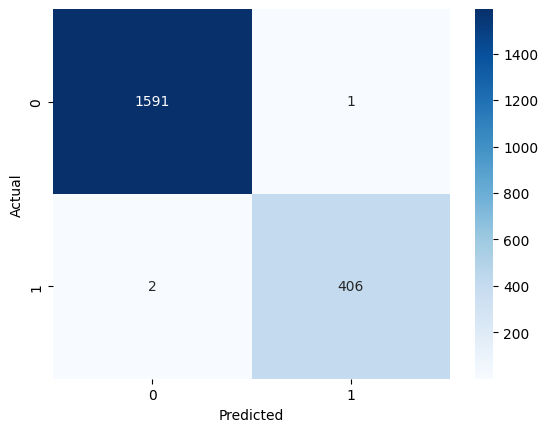

In [37]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [38]:
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Precision: 0.9975429975429976
Recall: 0.9950980392156863
F1: 0.996319018404908
ROC AUC: 0.9990624076263672


In [41]:
joblib.dump(model_logistic, "log_reg_model_17-9-2025.pkl")

['log_reg_model_17-9-2025.pkl']

In [42]:
residuals = y_test - y_prob

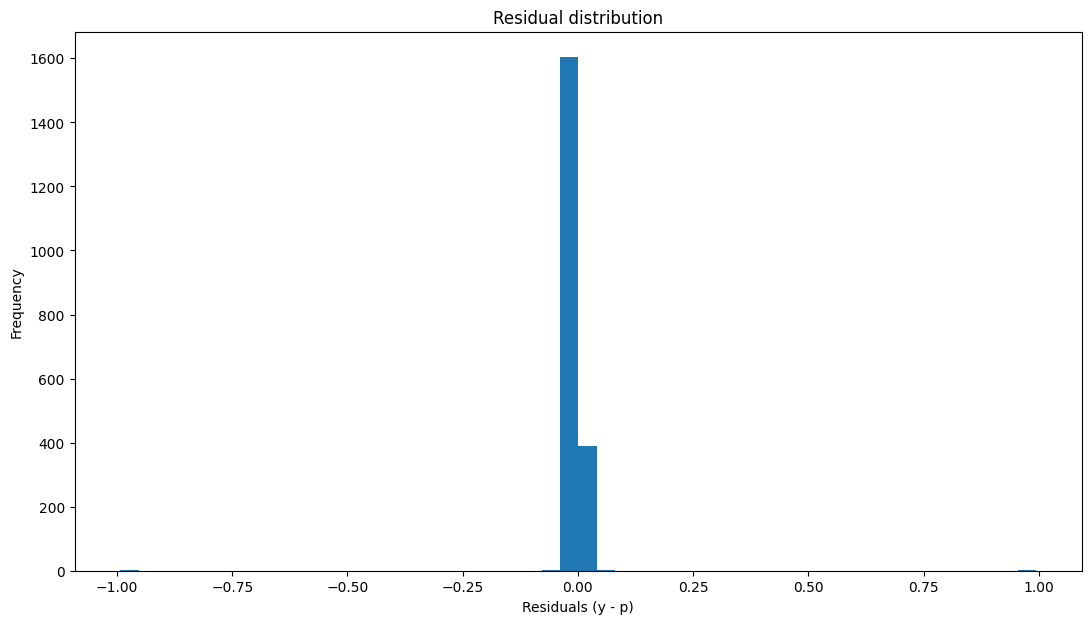

In [45]:
plt.figure(figsize=(13,7))
plt.hist(residuals, bins=50)
plt.xlabel("Residuals (y - p)")
plt.ylabel("Frequency")
plt.title("Residual distribution")
plt.show()